In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE =256
BATCH_SIZE =32
CHANNELS = 3
EPOCHS =10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names



['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 0 1 1 1 1 1 0 0 2 0 1 1 1 0 1 1 0 0 1 2 1 0 0 2 1 0 1]


[0 0 0 2 0 1 0 1 0 0 0 1 0 0 1 0 2 0 1 1 0 0 1 2 0 1 1 2 1 1 1 1]


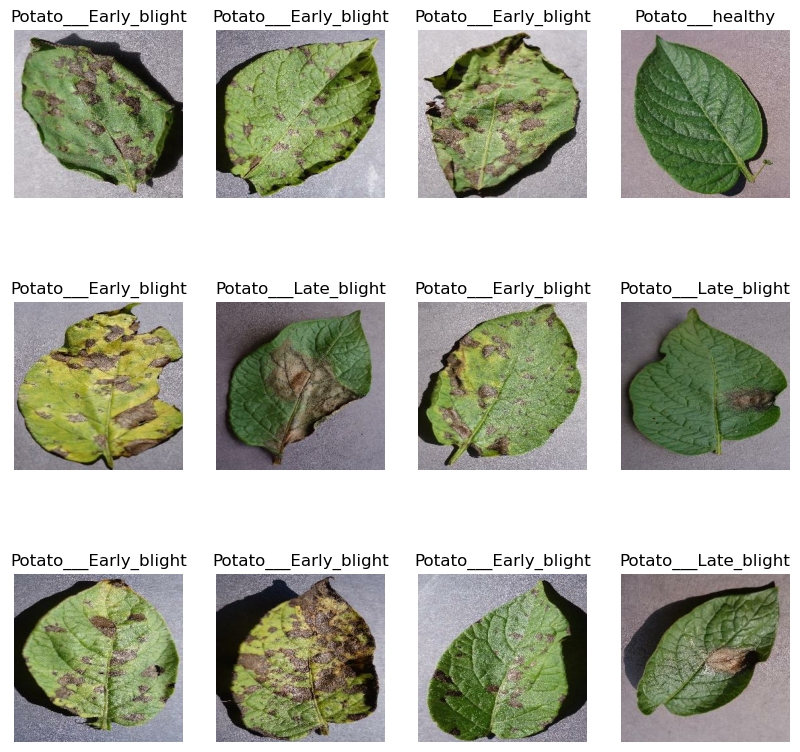

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    print(label_batch.numpy())

    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### TRAINING THE MODEL

1) 80% data for training the model


2) 10% for validatoin 


3) And remaining 10% for test model

In [7]:
len(dataset)


68

In [8]:
train_size = 0.8
train = len(dataset)*train_size
train

54.400000000000006

In [9]:
train_ds = dataset.take(int(train))
len(train_ds)

54

In [10]:
test_ds = dataset.skip(int(train))
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def train_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = train_test_split(dataset)
len(val_ds)


6

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [17]:
# Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')   
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 256, 3)        0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (256, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (256, 127, 127, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (256, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (256, 62, 62, 64)         0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds, 
    epochs= EPOCHS ,
    batch_size= BATCH_SIZE, 
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 92s 2s/step - loss: 0.9364 - accuracy: 0.4589 - val_loss: 0.8615 - val_accuracy: 0.5260
Epoch 2/10
54/54 [==============================] - 84s 2s/step - loss: 0.8473 - accuracy: 0.5914 - val_loss: 0.6776 - val_accuracy: 0.6979
Epoch 3/10
54/54 [==============================] - 83s 2s/step - loss: 0.5438 - accuracy: 0.7720 - val_loss: 0.4345 - val_accuracy: 0.8490
Epoch 4/10
54/54 [==============================] - 85s 2s/step - loss: 0.3637 - accuracy: 0.8559 - val_loss: 0.2888 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 87s 2s/step - loss: 0.2786 - accuracy: 0.8964 - val_loss: 0.3244 - val_accuracy: 0.8958
Epoch 6/10
54/54 [==============================] - 86s 2s/step - loss: 0.2667 - accuracy: 0.8929 - val_loss: 0.2341 - val_accuracy: 0.9010
Epoch 7/10
54/54 [==============================] - 87s 2s/step - loss: 0.2141 - accuracy: 0.9230 - val_loss: 0.3596 - val_accuracy: 0.8750
Epoch 8/10
54/54 [==

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


score = model.evaluate(test_ds)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

y_pred = model.predict(test_ds)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_true_classes = y_true

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

print("Classification Report:")
print(class_report)



8/8 [==============================] - 4s 540ms/step - loss: 0.1787 - accuracy: 0.9297
Test Loss: 0.1787213534116745
Test Accuracy: 0.9296875
8/8 [==============================] - 4s 530ms/step
Confusion Matrix:
[[44 56 14]
 [54 61  6]
 [12  6  3]]
Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.40      0.39      0.39       114
 Potato___Late_blight       0.50      0.50      0.50       121
     Potato___healthy       0.13      0.14      0.14        21

             accuracy                           0.42       256
            macro avg       0.34      0.34      0.34       256
         weighted avg       0.42      0.42      0.42       256



In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

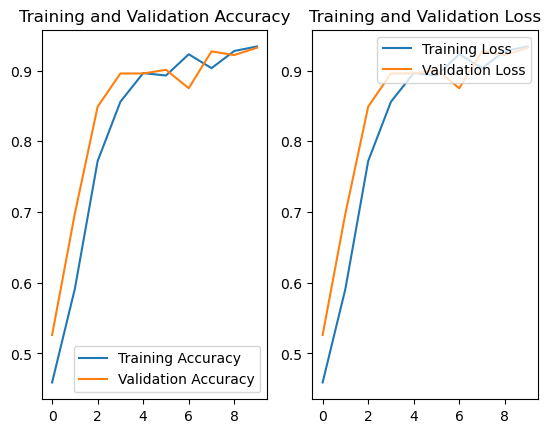

In [28]:
#plt.figure = (figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), acc, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation Loss')

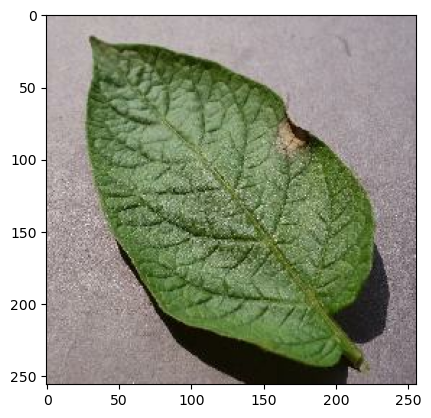

In [29]:
for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 771ms/step
predicted label: Potato___Late_blight


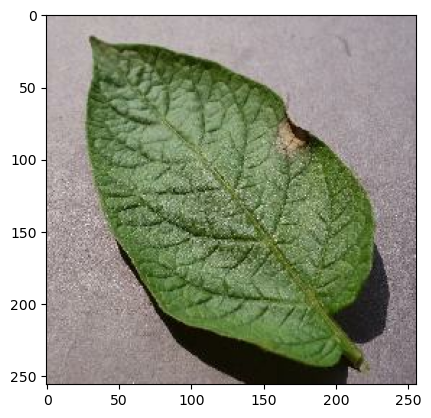

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 93ms/step


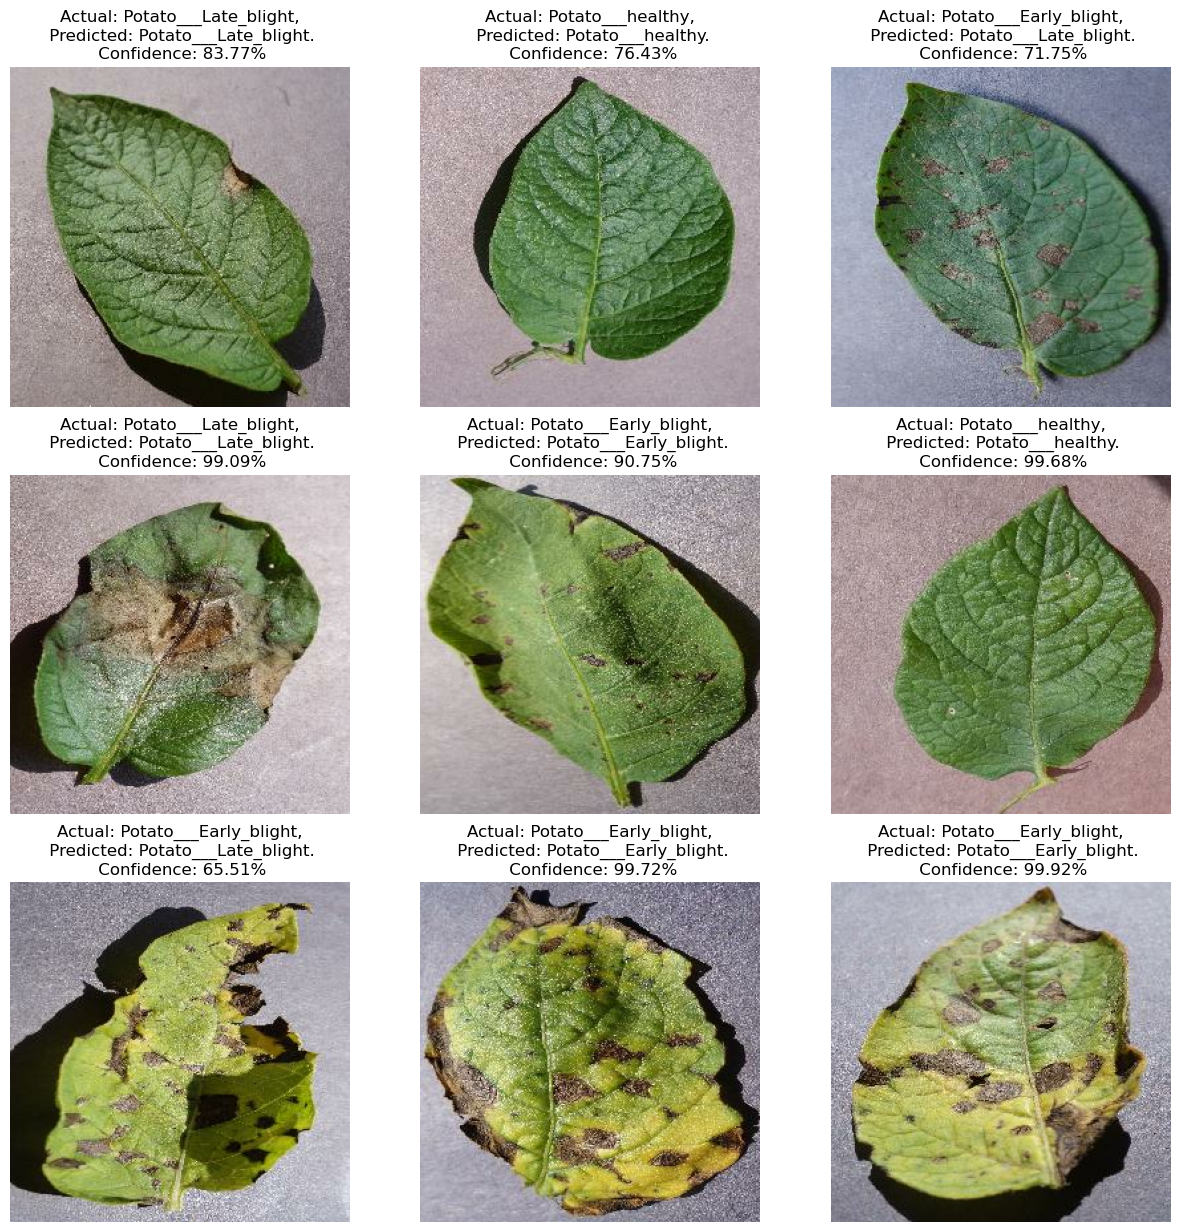

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
model.save("potato_detection_model.h5")

C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
